# Unsupervised Learning: clustering

# Outline

1. [Clustering: motivation](#motivation)
2. [Partitional methods](#partition)
3. [How to choose K](#validation)
5. [Density based methods](#density)
6. [Neighbour based methods](#neigh)

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy as sp
import sklearn.cluster as skcluster
import sklearn.metrics as skmetrics

<a id="motivation"></a>

## Clustering

Clustering is the perhaps the main task in unsupervised learning: it aims to to find **similarity groups** in data.

In a low dimensional space it may be an easy task:

<div>
<img src="clusters.png" width="500"/>
</div>

But topology may turn it in a more complicated one:

<div>
<img src="difficult.png" width="500"/>
</div>

### What you need to cluster data
- A set of features with which compare data
- A criterion for comparing pairs of instances $\rightarrow$ a distance,similarity,dissimilarity definition
- A criterion fo assigning instances to the same or different clusters given their similarity $\rightarrow$ a clustering algorithm
- A way to assess the results given that **there is now right answer but many may be utterly wrong nevertheless**

### An incomplete classification of algorithms

1. Partitional: try to decompose data in set of disjoint groups, i.e. optimise the partitioning of points wrt to a cost function. Example: K-Means or Fuzzy C-Means.  
2. Hierarchical: classify points in successive groups of increasing size and decreasing similarity (bottom up or agglomerative) or viceversa (top-down or divisive). Example: Ward.  
3. Density based: given the distance metric, create neighbourhoods of points i.e. identify zones with high density of points and build clusters around them.

<a id="partition"></a>

## Partition methods

### K-Means

Given a pre-set number of $K$ clusters (i.e. partitions of the feature space) generated with some bootstrap procedure, the algorithm tries to assign each data point to the $K^{th}$ cluster in way that minimizes the internal variance of the cluster (**WSS**) until no further change in WSS is observed, i. e. by minimization of: 
$$ J = \sum_K \sum_{i \in C_k} ||x_i -\mu_k||^2 $$ 
WSS is calculated with respect to the cluster *mean* $\mu_k$ (or *center*) in the feature space

$$ \mu_k = \frac{1}{C_k}\sum_{x\in C_k} x $$
Since usually $K$ is unknown is common to run the algorithm with different values of $K$ and search for an optimal value.

### K Means algorithm

    Bootstrap the procedure by assigning the K initial centers
    while not converged
        for x in data
            compute d(x,K)
            assign x to nearest k
        compute new centroids

### Hands on

In [2]:
def gaussian_blobs(N, k):
    """
    create k gaussian blobs from a total N points in 2D
    """
    C = np.random.uniform(low=-1,high=1,size=k*2)
    C.shape = [k,2]
    n = N//k
    X = np.empty((N,2))
    for ki in range(k):
        x = np.random.normal(scale=np.random.uniform(low=0.05,high=0.1),size=n*2)
        x.shape = [n,2]
        X[ki*n:(ki+1)*n] = x + C[ki]
    np.random.shuffle(X)
    return X

In [3]:
np.random.seed(0)
random.seed(0)
blobs = gaussian_blobs(500,10)
blobs.shape

(500, 2)

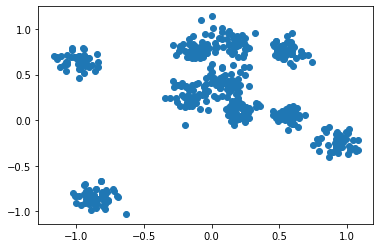

In [4]:
x = blobs[:,0]
y = blobs[:,1]
plt.scatter(x,y)

In [5]:
min_cl = 2
max_cl = 10
wss = list()
clusters = list()
centers = list()
for n in range(min_cl,max_cl+1):
    estimator = skcluster.KMeans(n_clusters=n, init='random')
    estimator.fit_predict(blobs)
    clusters.append(estimator.labels_)
    #coordinates of the centers in the feature space
    centers.append(estimator.cluster_centers_)
    wss.append(estimator.inertia_)

Text(0.5, 1.0, 'elbow criterion')

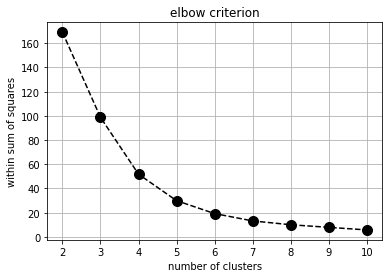

In [6]:
plt.plot(list(range(min_cl,max_cl+1)),wss,'k--',marker='o',ms='10')
plt.grid(True)
plt.xlabel('number of clusters')
plt.ylabel('within sum of squares')
plt.title('elbow criterion')

#### Three clusters

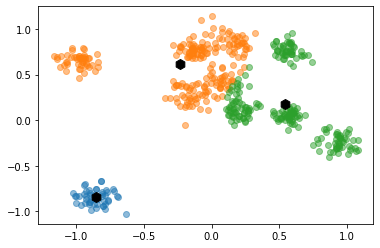

In [7]:
for i in range(3):
    plt.scatter(blobs[clusters[1]==i,0], blobs[clusters[1]==i,1], cmap=plt.cm.get_cmap('RdBu'), alpha=0.5)
plt.scatter(centers[1][:,0], centers[1][:,1], marker='h', c='k', s=100)

#### Five clusters

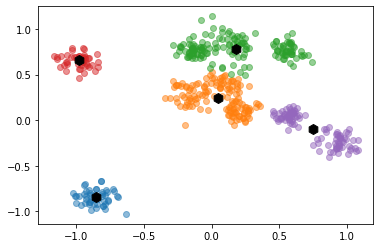

In [8]:
for i in range(5):
    plt.scatter(blobs[clusters[3]==i,0], blobs[clusters[3]==i,1], cmap=plt.cm.get_cmap('RdBu'), alpha=0.5)
plt.scatter(centers[3][:,0], centers[3][:,1], marker='h', c='k', s=100)

### Exercise

Implement K Means, given a random initialization of the points.

<div>
<img src="gears.png" width="500"/>
</div>

### Solution

In [9]:
np.random.seed(42)

In [10]:
def simple_kmeans(X, k, conv, maxsteps):
    """
    simple minimization of KM cost function
    """
    # assign initial centers
    npoints = X.shape[0]
    nfeatures = X.shape[1]
    centers = np.random.uniform(low=np.min(X),high=np.max(X),size=nfeatures*k)
    centers.shape = (k, nfeatures)
    empty_clusters = False
    clusters = -np.ones(npoints ,dtype='int')
    steps = 0
    #start algorithm
    while True:
        # assign clusters
        dist = sp.spatial.distance.cdist(X, centers)
        for pj in range(npoints):
            clusters[pj] = np.argmin(dist[pj])
        if np.any(clusters==-1):
            empty_clusters = True
            break
        #calculate cost
        wss = .0
        for i in range(k):
            wss = wss + np.sum(np.sum(dist[clusters==i,i]**2,axis=0))
        steps += 1
        if wss < conv or steps >= maxsteps:
            break
        # new centers
        for i in range(k):
            points = X[clusters==i]
            centers[i] = np.average(points, axis=0)
    if empty_clusters:
        print(clusters)
        raise ValueError("Found empty clusters")
    else:
        return wss,centers,clusters,steps

In [11]:
mywss, mycenters, myclusters, steps = simple_kmeans(blobs, 3, 1e-5, 10)
print("WSS is ",mywss," after ",steps," steps")

WSS is  98.81143920557584  after  10  steps


In [12]:
estimator = skcluster.KMeans(n_clusters=3, init='random', n_init=1)
estimator.fit_predict(blobs)
estimator.inertia_, estimator.inertia_-mywss, estimator.n_iter_

(152.8096577606003, 53.99821855502445, 13)

### Initialization

In the simple example above KM is initialized with random centers. However this can increase the computational cost and perform badly in specific cases.  

**KMeans++**  
Basic idea: having uniform probability for initial centers is bas because a region may be oversampled with respect to others. Alternative:
    
    Assign first center randomly
    while (initial centers to be assigned)
    compute D(x, nearest) between non centers x and already selected centers
    select a point in the x set with probability ~ D(x^2)
   

### KMeans variants

- KMedians: assign centers using the median along each coordinate
- KMedoids: calculate the cost using the nearest data set member to center of each cluster

KMedoids is a simpler approach to the problem solved by the [**Partition around medoids**](https://en.wikipedia.org/wiki/K-medoids) method 

### Exercise

Implement K Means++

<div>
<img src="gears.png" width="500"/>
</div>

### Solution

In [13]:
def kmeanspp(K, X):
    """
    initialization with kmeans++
    """
    #choose 1st center
    centers = list()
    c = np.random.randint(0, X.shape[0])
    centers.append(c)
    labels = -np.ones(X.shape[0],dtype='int')
    # squared distances; we start working only with points 
    # in the dataset
    # the probability of picking a point x as new center
    # is ~ to the distance from the nearest already picked center
    while len(centers) < K:
        for c in centers:
            labels[c] = c
        MX = X[labels==-1]
        D2 = np.array([min([np.linalg.norm(x-c)**2 for c in centers]) for x in MX])
        cumprob = (D2/D2.sum()).cumsum()
        coin = np.random.random()
        try:
            ind = int(np.argwhere(cumprob >= coin)[0][0])
        except:            
            print("Error in kmeans++",cumprob,coin)
        centers.append(ind)
    return centers

[416, 325, 102, 136, 106]


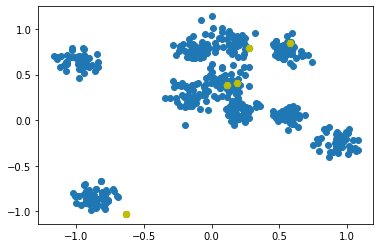

In [14]:
centerspp = kmeanspp(5, blobs)
print(centerspp)
x = blobs[:,0]
y = blobs[:,1]
plt.scatter(x,y)
plt.scatter(x[centerspp], y[centerspp], c="y", marker='H', s=50)

<a id="validation"></a>

## How to choose K

By definition 
$$\lim_{k\rightarrow\infty} wss = 0 $$
so how to choose the right $k$? We want a _break even point_ that can be found in the WSS graph:

Text(0.5, 1.0, 'elbow criterion')

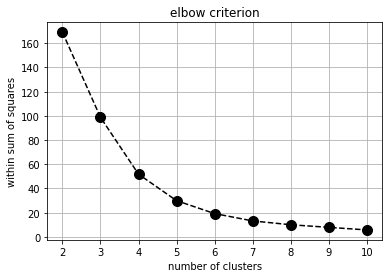

In [15]:
plt.plot(list(range(min_cl,max_cl+1)),wss,'k--',marker='o',ms='10')
plt.grid(True)
plt.xlabel('number of clusters')
plt.ylabel('within sum of squares')
plt.title('elbow criterion')

Choosing too few points would be a form of _underfitting_ since you assign points to a class they not belong to.  
Choosing too many clusters would be a form of _overfitting_ since you create artificial distinctions.  

Ideally you want to have clusters that are as homogeneous as possible and as separated as possible:
- Inter-clusters distance $\rightarrow$ maximized
- Intra-cluster distance $\rightarrow$ minimized

what if the wss plot is more linear?

#### CH score

The Calinski Harabaz Score, also known as pseudo F function is an *internal validation* criterion, i. e. a score that tries to assess the compactness of clusters with respect to their distance. It is defined as:
$$
CH = \frac{BSS/(k-1)}{WSS/(n-k)}
$$
where $n$ and $k$ are the number of data points and clusters, respectively; $WSS$ and $BSS$ are the *within* and *between* sum of square distances from the cluster mean (that is, the variances) and normalized by the number of degrees of freedom. CH score weights the internal variance with respect to inter-cluster distances. $BSS$ can be simply evaluted as: 
$$ BSS = TSS - WSS $$
where $T$ stands for *total*. Usually the first maximum of the CH score with respect to the number of clusters is used as an indicator for a better clustering (because the limiting behaviour of KM is to give one clsuter for each element).

In [16]:
nc = list()
scores = list()
for i in range(min_cl,max_cl+1):
    nc.append(i)
    estimator = skcluster.KMeans(n_clusters=i)
    estimator.fit_predict(blobs)    
    scores.append(skmetrics.calinski_harabasz_score(blobs, estimator.labels_))

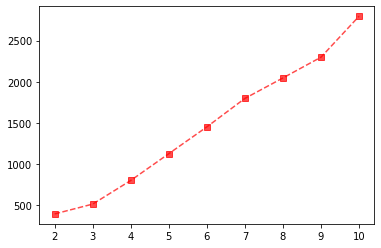

In [17]:
plt.plot(nc,scores,ls="--",marker="s",alpha=0.7,label="psF",color="r")

#### Silhouette score

SC is calculated using the _mean intra-cluster distance_ $a$ and the _mean nearest-cluster distance_ $b$. SC for a point is 
$$\frac{b - a} {max(a, b)} $$ . To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. The final SC is the mean of all silhouettes

In [18]:
nc = list()
scores = list()
for i in range(min_cl,max_cl+1):
    nc.append(i)
    estimator = skcluster.KMeans(n_clusters=i)
    estimator.fit_predict(blobs)    
    scores.append(skmetrics.silhouette_score(blobs, estimator.labels_))

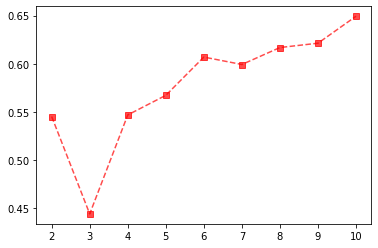

In [19]:
plt.plot(nc,scores,ls="--",marker="s",alpha=0.7,label="psF",color="r")

Many other criteria are available:
- Davies Bouldin Index
- Dunn index (many variants)
- Gap statistic
- fK score

No "right answer" in ML $\rightarrow$ no "best validation". Much depends on the chosen features and specific problem.

## Density based methods

KM tries to divide the data domain in the feature space in homogeneous regions. It assumes that:
- any point belongs to a cluster; put in another way KM is sensitive to outliers
- clusters are approximately *convex* since they are found by minimization of a cost function
- clusters are linearly separable
- clusters do not overlap  
None of these assumptions is necessarily true. Consider the following data set:

In [20]:
npoints = int(1e3)
x = 2*np.random.rand(npoints)-1. 
y = 2*np.random.rand(npoints)-1. 
r = x**2 + y**2
donut = np.logical_and(r<=1,r>= 0.65 )
d0 = np.vstack((x[donut],y[donut])).T
x = 4*np.random.rand(2*npoints)-2. 
y = 4*np.random.rand(2*npoints)-2. 
r = x**2 + y**2
donut = np.logical_and(r<=4,r>= 3. )
d1 = np.vstack((x[donut],y[donut])).T
x = 5*np.random.rand(npoints//10)-2.5 
y = 5*np.random.rand(npoints//10)-2.5 
r = x**2 + y**2
circle = r<= 5
d2 = np.vstack((x[circle],y[circle])).T
two_donuts = np.concatenate((d0,d1,d2))

(-2.3432627459144495,
 2.3024600580694354,
 -2.296699585992844,
 2.3828911218325715)

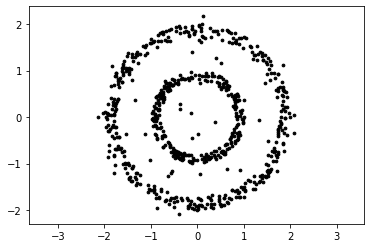

In [21]:
plt.scatter(two_donuts[:,0],two_donuts[:,1],c='k',s=7.5)
plt.axis('equal')

In [22]:
estimator = skcluster.KMeans(n_clusters=2)
clusters = estimator.fit_predict(two_donuts)

(-2.3432627459144495,
 2.3024600580694354,
 -2.296699585992844,
 2.3828911218325715)

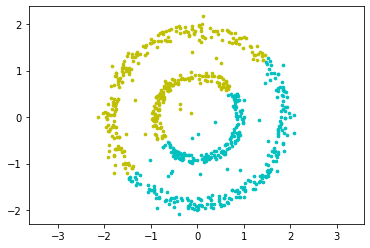

In [23]:
plt.scatter(two_donuts[estimator.labels_==0,0],two_donuts[estimator.labels_==0,1],c="y",s=7)
plt.scatter(two_donuts[estimator.labels_==1,0],two_donuts[estimator.labels_==1,1],c="c",s=7)
plt.axis("equal")

Features of the "donut" data set:
- not all points belong to clusters $\rightarrow$ outliers and noise
- the clusters are (hyper)spheres
- the density is uniform

we could try to develop a methods based on not holding as true the assumptions above, i. e.:
- distinguish between noise and points
- determine denser and less dense regions and define clusters as dense regions
- arbitrary shape

formally, we assume that points represent an _underlying probability distribution_ which can have many peaks and valleys

### DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is the first and most well-known density-based clustering algorithm, first introduced in 1996 by Ester et. al. 

DBSCAN does not need the number of clusters (actually it does not assume the *presence of clusters altogheter*). Rather it infers the number of clusters based on the data, and it can discover clusters of arbitrary shape (and not only ellipsoids).

#### Definitions

- Clusters  are dense regions in the data space, separated by regions of lower object density
- Given a point $P$, a neighbourhood of radius $\epsilon$ is the set of points within distance $\epsilon$ from $P$.
- A cluster is defined as a maximal set of density-connected points

- A point is a *core point* if it more than `minPTS` are within $\epsilon$. These are points that are at the interior of a cluster.
- A *border point* has density ($\rho$) less than `minPTS` within $\epsilon$, but is in the neighbourhood of a core point.
- An *outlier* or *noise point* is any other point
- A point is **`b`** *density-reachable* from **`a`** if is in its neighbourhood or if there is a sequence of points *density-reachable* from the neighbourhood of **`a`**; density-reachability is asymmetric.

Select two parameters:

- $\epsilon$: The radius of neighbourhoods around a data point p.
- `minPts`: The minimum number of data points in a neighbourhood to form a cluster.

then pick an arbitrary point. If there are more than `minPts` points within a distance of $\epsilon$ from that point (including the original point itself), we consider all of them to be part of a "cluster". We then expand that cluster by checking all of the new points and seeing if they too have more than `minPts` within a distance of $\epsilon$, growing the cluster recursively if so.

    for p in points:
        if p not in assigned_points
            if p is a core:
                collect all density-reachable points and assign to the same cluster of p
            else:
                p is an outlier

<div>
<img src="density.png" width="500"/>
</div>

#### Run parameters

For points in a cluster, their $k^{th}$ nearest neighbors are at roughly the same distance while outliers are farther away: a rule of thumb for setting DBSCAN parameters could be:
1. set `minPTS` to a a tiny number of total instances in the data set (~1% or 2%) to indicate a local density value
2. calculate the average distance for that `minPTS` value

10


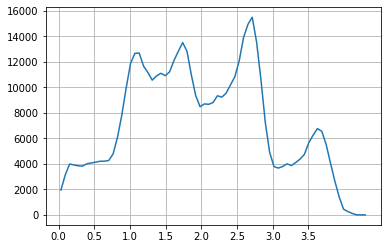

In [24]:
from sklearn.neighbors import kneighbors_graph

minPTS = int(1.5*two_donuts.shape[0]/100)
print(minPTS)
nb = two_donuts.shape[0]//minPTS 

D = sp.spatial.distance.squareform(sp.spatial.distance.pdist(two_donuts)).ravel()
h,b = np.histogram(D,bins=nb)
mp = (b[:-1]+b[1:])/2
plt.plot(mp,h)
plt.xticks(ticks=np.arange(0, 4, step=0.5))
plt.grid(True)

{0, 1, -1}


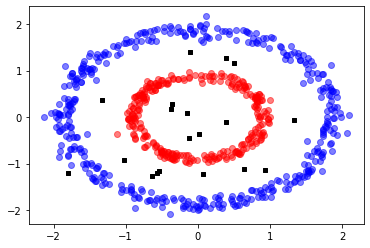

In [25]:
from sklearn.cluster import DBSCAN
estimator = DBSCAN(eps=0.25, min_samples=minPTS, metric="euclidean")
clusters  = estimator.fit_predict(two_donuts)
print(set(clusters))
plt.scatter(two_donuts[clusters==0,0],two_donuts[clusters==0,1],c="r",alpha=0.5)
plt.scatter(two_donuts[clusters==1,0],two_donuts[clusters==1,1],c="b",alpha=0.5)
plt.scatter(two_donuts[clusters==-1,0],two_donuts[clusters==-1,1],c="k",s=15,marker="s")

Other shapes:

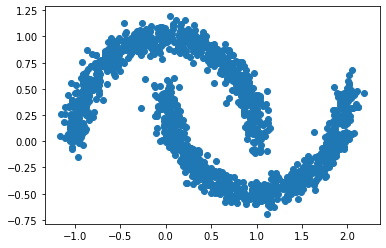

In [26]:
from sklearn import datasets
noisy_moons, labels = datasets.make_moons(n_samples=1500, noise=.075)
plt.scatter(noisy_moons[:,0],noisy_moons[:,1])

22


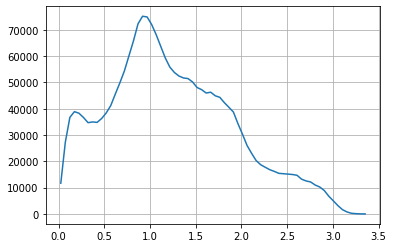

In [27]:
minPTS = int(1.5*noisy_moons.shape[0]/100)
print(minPTS)
nb = noisy_moons.shape[0]//minPTS 

D = sp.spatial.distance.squareform(sp.spatial.distance.pdist(noisy_moons)).ravel()
h,b = np.histogram(D,bins=nb)
mp = (b[:-1]+b[1:])/2
plt.plot(mp,h)
plt.xticks(ticks=np.arange(0, 4, step=0.5))
plt.grid(True)

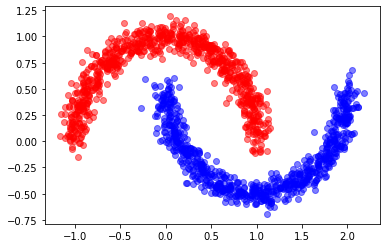

In [28]:
estimator = DBSCAN(eps=0.2, min_samples=22)
clusters  = estimator.fit_predict(noisy_moons)
plt.scatter(noisy_moons[clusters==0,0],noisy_moons[clusters==0,1],c="r",alpha=0.5)
plt.scatter(noisy_moons[clusters==1,0],noisy_moons[clusters==1,1],c="b",alpha=0.5)
plt.scatter(noisy_moons[clusters==-1,0],noisy_moons[clusters==-1,1],c="k",s=15,marker="s")

Problems with DBSCAN:
- the parameter space (`minPTS`,$\epsilon$) is a rugged surface: difficult to explore
- cannot handle varying densities
- how to validate? the scores described above do not consider _noise_; a simple solution (Moulavi et al., 2016) may be to penalize runs with a hign number of clusters, i. e. (VS=validation score, $n_c$ number of points in clusters, $n_t$ sample size.):
$$ VS = VS_0 \frac{n_c}{n_t} $$

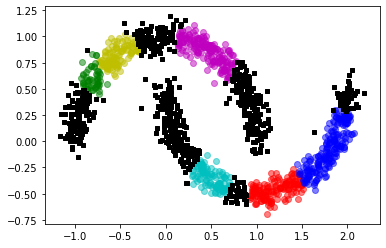

In [53]:
estimator = DBSCAN(eps=0.23, min_samples=110)
clusters  = estimator.fit_predict(noisy_moons)
plt.scatter(noisy_moons[clusters==0,0],noisy_moons[clusters==0,1],c="r",alpha=0.5)
plt.scatter(noisy_moons[clusters==1,0],noisy_moons[clusters==1,1],c="b",alpha=0.5)
plt.scatter(noisy_moons[clusters==2,0],noisy_moons[clusters==2,1],c="m",alpha=0.5)
plt.scatter(noisy_moons[clusters==3,0],noisy_moons[clusters==3,1],c="y",alpha=0.5)
plt.scatter(noisy_moons[clusters==4,0],noisy_moons[clusters==4,1],c="g",alpha=0.5)
plt.scatter(noisy_moons[clusters==5,0],noisy_moons[clusters==5,1],c="c",alpha=0.5)
plt.scatter(noisy_moons[clusters==-1,0],noisy_moons[clusters==-1,1],c="k",s=15,marker="s")

More advanced versions like `OPTICS` and `HDBSCAN` are available

### Density Peaks

Laio and Rodrigues _density peaks_ is based on searching for points far from each other (_distance_ $\delta$) and with high neighbour density $\rho$) i. e. for outliers in the _decision graph_ $\delta(\rho)$. The only parameter needed is a cutoff distance to define neighborhoods. Local density around a point i is evaluated using the following kernel:  
$$ \rho_i = \sum_j \chi(d_{ij} - d_c) $$ number of data points within cutoff  
$$ \delta_i = min_{j:\rho_j>rho_i} d_{ij} $$ distance from the higher density point  

DP by default does not include a noise definition by "halos" may be calculated once cluster have been assigned  
at variance with DBSCAN it provides a centroid definition  

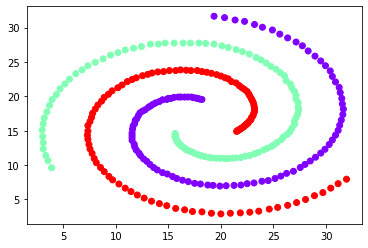

In [30]:
spiral = np.loadtxt("spiral.dat")
Xspiral = spiral[:,0]
Yspiral = spiral[:,1]
Cspiral = spiral[:,2]
plt.scatter(Xspiral, Yspiral, c=Cspiral, cmap=plt.cm.get_cmap('rainbow'))

In [54]:
import density_peaks as dp
estimator = dp.density_peaks(cutoff="auto",percent=2.0,kernel="gaussian",metric="euclidean")
print("Cutoff: ",estimator.cutoff)
rho,delta = estimator.decision_graph(X=spiral[:,:2])
nneigh = estimator.nneigh

Determining cutoff using a % of neighbors= 2.0
Cutoff:  auto


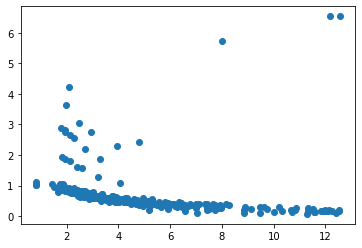

In [55]:
plt.scatter(rho,delta)

In [56]:
centroids,points = estimator.get_centroids(rmin=8,dmin=5)
print("Found ",estimator.nclusters," clusters")
print("Cores: ",centroids)

Found  3  clusters
Cores:  [ 96 199 301]


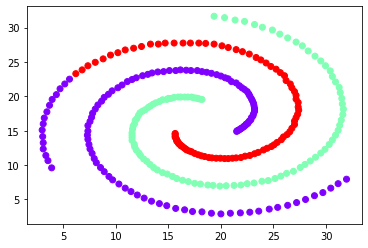

In [57]:
clusters = estimator.assign_points()
plt.scatter(Xspiral, Yspiral, c=clusters, cmap=plt.cm.get_cmap('rainbow'))

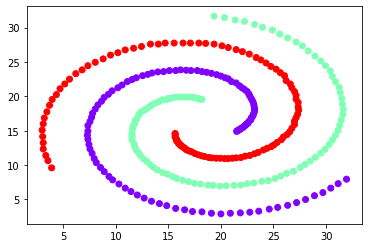

In [35]:
robust_cluster = estimator.create_halo()
plt.scatter(Xspiral, Yspiral, c=robust_cluster, cmap=plt.cm.get_cmap('rainbow'))

<a id="neigh"></a>

## Neighbour based methods

### Jarvis Patrick

See Jarvis, R. A.; Patrick, E. A. Clustering Using a Similarity Measure Based on Shared Nearest Neighbors IEEE Trans. Comput. 1973, C22, 1025-1034.

Calculate the set of $K$ nearest neighbors for each structure. Note that the structure is set as its $0^{th}$ neighbor. Two structures cluster together if:
- they are in each others list of nearest neighbors
- they have at least $K_{min}$ of their $K$ nearest neighbors in common.

### Shared nearest neighbours

Ertoz, L.; Steinbach, M.; Kumar, V. A New Shared Nearest Neighbor Clustering Algorithm and Its Applications. In Workshop on clustering high dimensional data and its applications at 2nd SIAM international conference on data mining; 2002; pp 105–115.

Combines ideas from DBSCAN and JP. Very powerful method.

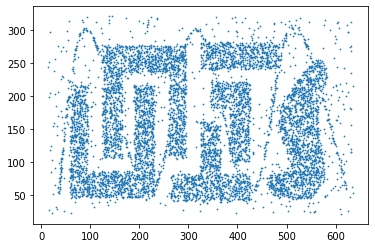

In [36]:
snn_example = np.loadtxt("snn.dat")
plt.scatter(snn_example[:,0], snn_example[:,1],s=0.5)

In [37]:
import jarvis_patrick
data = snn_example[::4]
D = sp.spatial.distance.squareform(sp.spatial.distance.pdist(data))
my_estimator = jarvis_patrick.SNN(K=20,minPTS=16,epsilon=8,metric="precomputed")
ncl, nn, cl = my_estimator.do_clustering(D=D)
ncl, nn

(8, 78)

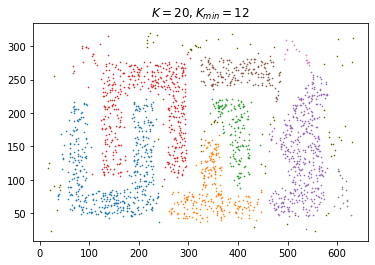

In [38]:
plt.title("$K=20, K_{min}=12$")
for i in set(cl):
    plt.scatter(data[cl==i,0],data[cl==i,1],cmap=plt.cm.get_cmap('RdBu'),s=0.4)
plt.scatter(data[cl==-1,0],data[cl==-1,1],s=0.2,marker='h',c='k',alpha=0.5)

## The End!